In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from mlxtend.classifier import StackingClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

In [5]:
train_data = pd.read_csv('train_s3TEQDk.csv')

In [6]:
print(train_data.head())
train_data.shape

         ID  Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  NNVBBKZB  Female   73       RG268          Other           X3       43   
1  IDD62UNG  Female   30       RG277       Salaried           X1       32   
2  HD3DSEMC  Female   56       RG268  Self_Employed           X3       26   
3  BF3NC7KV    Male   34       RG270       Salaried           X1       19   
4  TEASRWXV  Female   30       RG282       Salaried           X1       33   

  Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0             No              1045696        No        0  
1             No               581988        No        0  
2             No              1484315       Yes        0  
3             No               470454        No        0  
4             No               886787        No        0  


(245725, 11)

In [7]:
test_data = pd.read_csv('test_mSzZ8RL.csv')

In [8]:
print(test_data.head())
test_data.shape

         ID  Gender  Age Region_Code Occupation Channel_Code  Vintage  \
0  VBENBARO    Male   29       RG254      Other           X1       25   
1  CCMEWNKY    Male   43       RG268      Other           X2       49   
2  VK3KGA9M    Male   31       RG270   Salaried           X1       14   
3  TT8RPZVC    Male   29       RG272      Other           X1       33   
4  SHQZEYTZ  Female   29       RG270      Other           X1       19   

  Credit_Product  Avg_Account_Balance Is_Active  
0            Yes               742366        No  
1            NaN               925537        No  
2             No               215949        No  
3             No               868070        No  
4             No               657087        No  


(105312, 10)

In [9]:
train_data.info(), test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               -

(None, None)

In [10]:
train_data.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


In [11]:
test_data.describe()

,Age,Vintage,Avg_Account_Balance
count,105312.000000,105312.000000,1.053120e+05
mean,43.871002,46.842819,1.134195e+06
std,14.872890,32.273634,8.662430e+05
min,24.000000,7.000000,2.259700e+04
25%,30.000000,20.000000,6.039822e+05
50%,43.000000,32.000000,8.966345e+05
75%,54.000000,73.000000,1.371598e+06
max,85.000000,135.000000,9.908858e+06


In [12]:
train_data.nunique()

ID                     245725
Gender                      2
Age                        63
Region_Code                35
Occupation                  4
Channel_Code                4
Vintage                    66
Credit_Product              2
Avg_Account_Balance    135292
Is_Active                   2
Is_Lead                     2
dtype: int64

In [13]:
target_col = 'Is_Lead'

In [14]:
categorical = ['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']
continuous = ['Age', 'Vintage', 'Avg_Account_Balance']

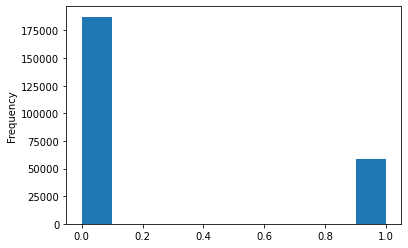

In [15]:
train_data.Is_Lead.plot.hist()

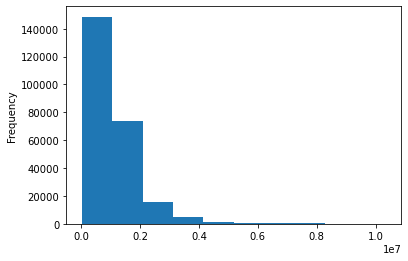

In [16]:
train_data.Avg_Account_Balance.plot.hist()

In [17]:
train_data = train_data[train_data['Avg_Account_Balance']<=max(test_data.Avg_Account_Balance)].reset_index(drop=True)

In [18]:
train_data

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...,...
245718,BPAWWXZN,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0
245719,HFNB7JY8,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245720,GEHAUCWT,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245721,GE7V8SAH,Female,28,RG273,Salaried,X1,31,No,407504,No,0


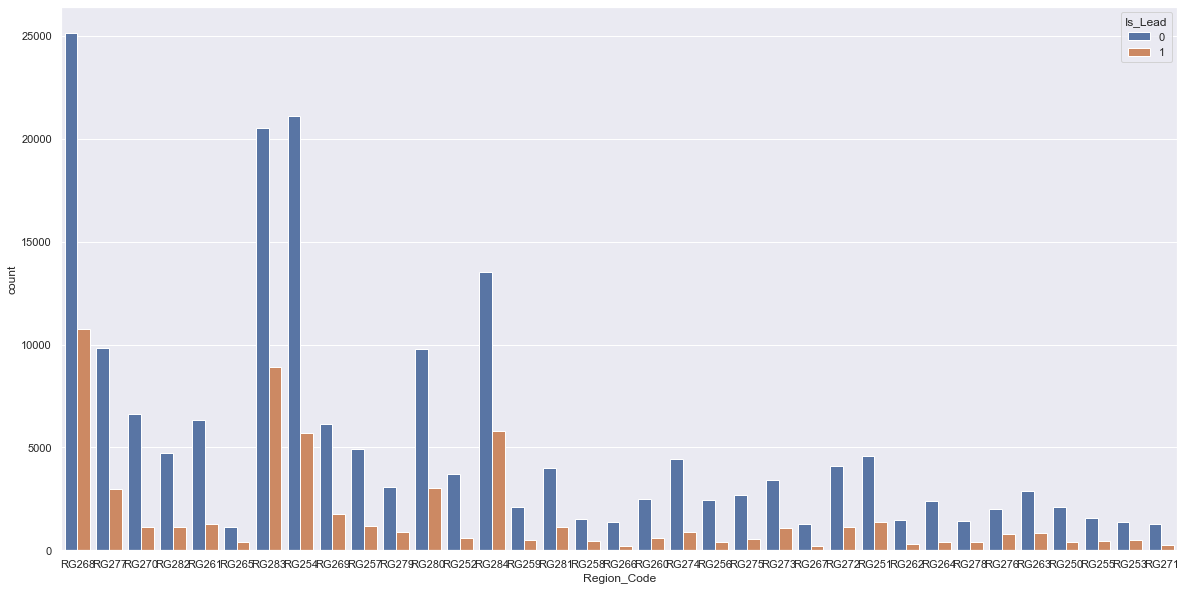

In [19]:
## Bivariate Analysis
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(data=train_data,x='Region_Code', hue='Is_Lead')

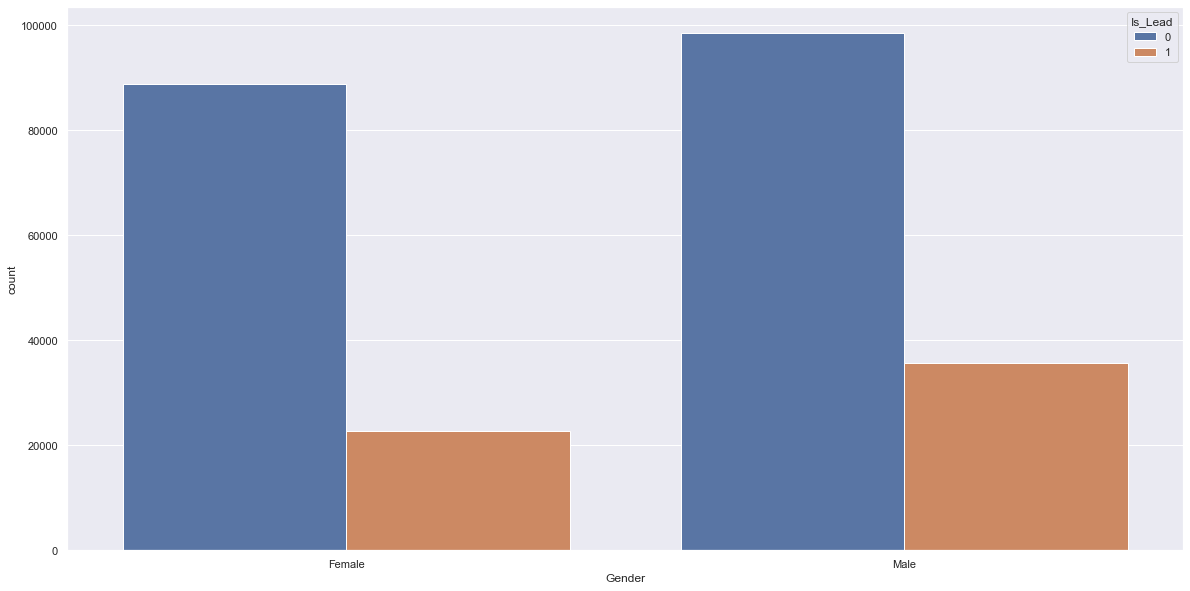

In [20]:
sns.countplot(data=train_data,x='Gender', hue='Is_Lead')

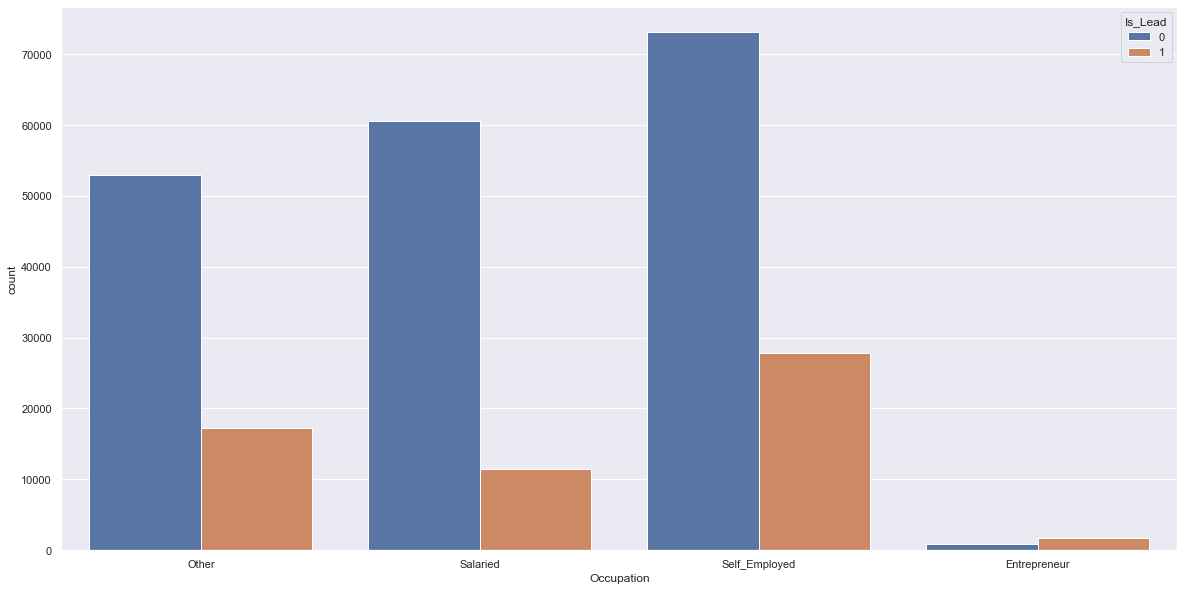

In [21]:
sns.countplot(data=train_data,x='Occupation', hue='Is_Lead')

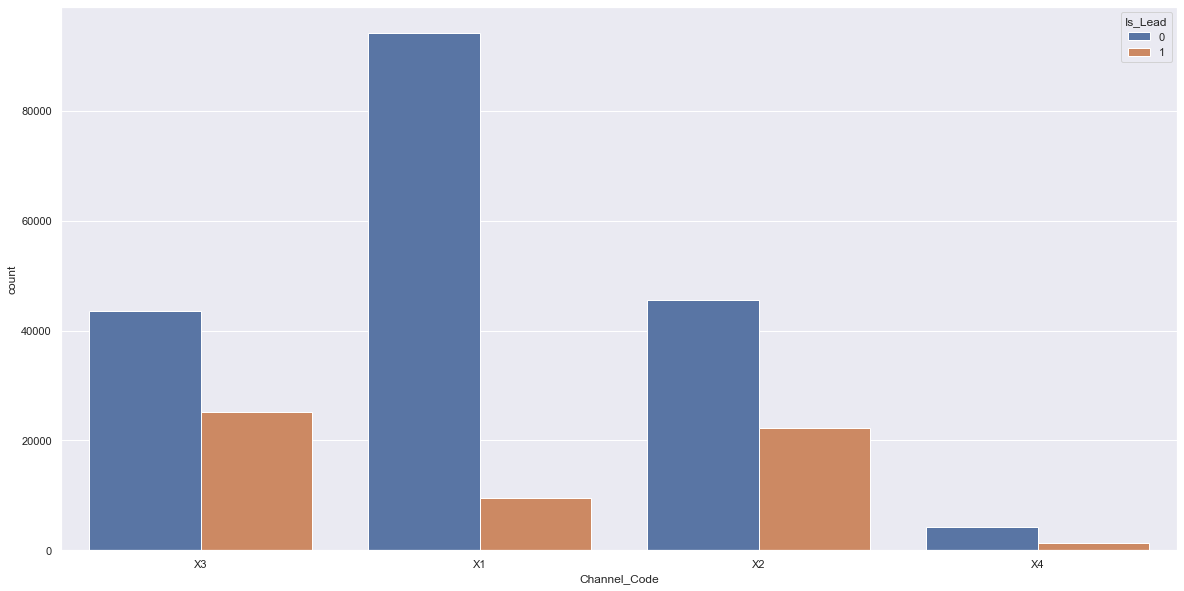

In [22]:
sns.countplot(data=train_data,x='Channel_Code', hue='Is_Lead')

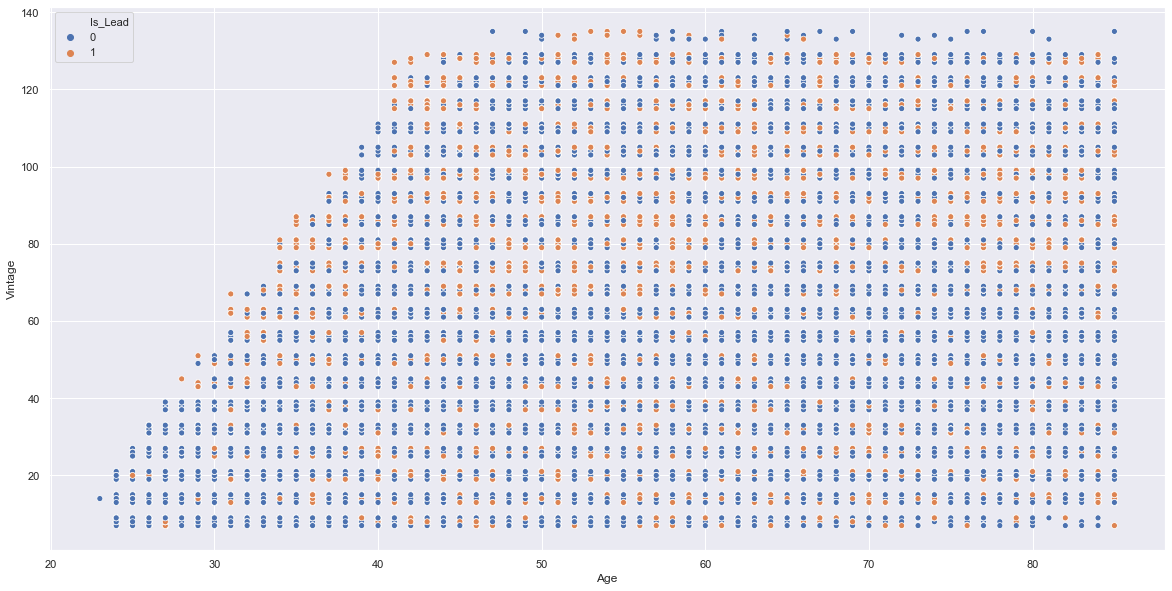

In [23]:
sns.scatterplot(data=train_data,x='Age', y='Vintage', hue='Is_Lead')

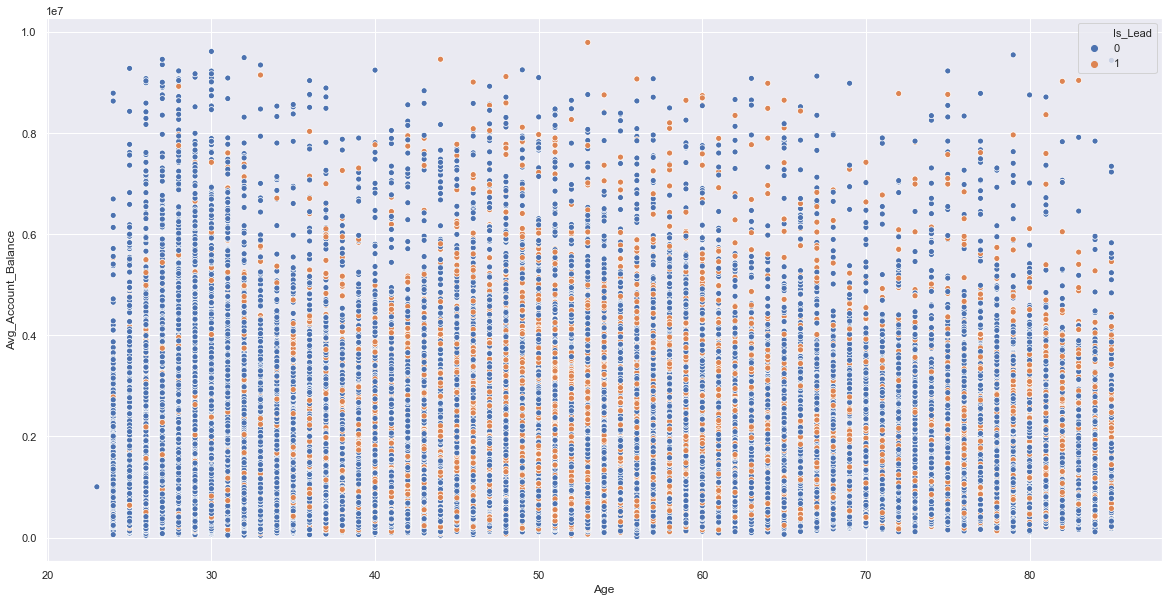

In [24]:
sns.scatterplot(data=train_data,x='Age', y='Avg_Account_Balance', hue='Is_Lead')

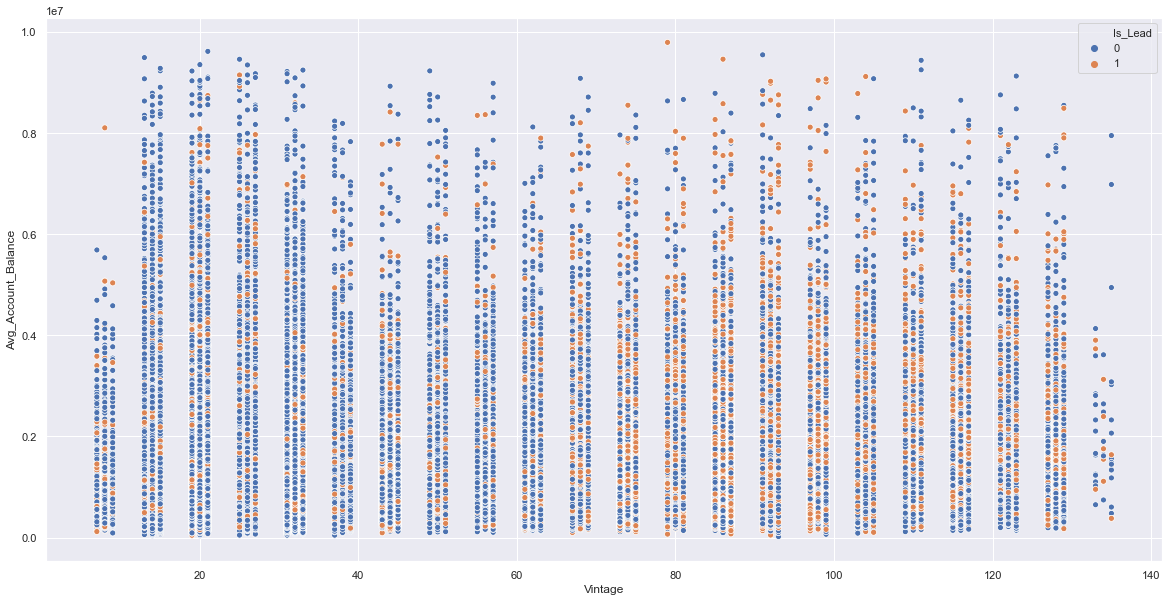

In [25]:
sns.scatterplot(data=train_data,x='Vintage', y='Avg_Account_Balance', hue='Is_Lead')

In [26]:
for i in categorical:
    print(train_data.groupby(i)['Is_Lead'].value_counts().nlargest(8))

Gender  Is_Lead
Male    0          98613
Female  0          88823
Male    1          35582
Female  1          22705
Name: Is_Lead, dtype: int64
Region_Code  Is_Lead
RG268        0          25160
RG254        0          21127
RG283        0          20531
RG284        0          13504
RG268        1          10773
RG277        0           9851
RG280        0           9766
RG283        1           8884
Name: Is_Lead, dtype: int64
Occupation     Is_Lead
Self_Employed  0          73045
Salaried       0          60503
Other          0          52983
Self_Employed  1          27841
Other          1          17189
Salaried       1          11496
Entrepreneur   1           1761
               0            905
Name: Is_Lead, dtype: int64
Channel_Code  Is_Lead
X1            0          94236
X2            0          45519
X3            0          43492
              1          25219
X2            1          22207
X1            1           9481
X4            0           4189
              1      

In [27]:
train_data.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [28]:
train_data.Credit_Product = train_data.Credit_Product.replace({'Yes':1, 'No':0})
test_data.Credit_Product = test_data.Credit_Product.replace({'Yes':1, 'No':0})

In [29]:
categorical.remove("Credit_Product")

In [32]:
le = LabelEncoder()

for feat in categorical:
    train_data[feat] = le.fit_transform(train_data[feat].astype(str))

In [33]:
train_data

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,0,73,18,1,2,43,0.0,1045696,0,0
1,IDD62UNG,0,30,27,2,0,32,0.0,581988,0,0
2,HD3DSEMC,0,56,18,3,2,26,0.0,1484315,1,0
3,BF3NC7KV,1,34,20,2,0,19,0.0,470454,0,0
4,TEASRWXV,0,30,32,2,0,33,0.0,886787,0,0
...,...,...,...,...,...,...,...,...,...,...,...
245718,BPAWWXZN,1,51,34,3,2,109,NaN,1925586,0,0
245719,HFNB7JY8,1,27,18,2,0,15,0.0,862952,1,0
245720,GEHAUCWT,0,26,31,2,0,13,0.0,670659,0,0
245721,GE7V8SAH,0,28,23,2,0,31,0.0,407504,0,0


In [34]:
selected_columns = ['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']

In [35]:
train_data = train_data.fillna(2)
test_data = test_data.fillna(2)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data[selected_columns], train_data[target_col], test_size=0.3,
                                                    random_state=0)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from mlxtend.classifier import StackingClassifier

In [37]:
models = []
models.append(('Logistic', LogisticRegression()))
models.append(('LightGBM', LGBMClassifier()))
models.append(('Tree', DecisionTreeClassifier()))
models.append(('Forest', RandomForestClassifier()))
models.append(('Boost', XGBClassifier()))
models.append(('Bayes', GaussianNB()))
models.append(('Neighbor', KNeighborsClassifier()))
models.append(('Hist', HistGradientBoostingClassifier()))
models.append(('Ada', AdaBoostClassifier()))

In [39]:
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("ROC~AUC score for", name, ":", metrics.roc_auc_score(y_test, y_pred))

ROC~AUC score for Logistic : 0.5
ROC~AUC score for LightGBM : 0.7500693876583568
ROC~AUC score for Tree : 0.7067364592487488
ROC~AUC score for Forest : 0.7555064026270203
[19:32:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/abhaya.panda/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


ROC~AUC score for Boost : 0.7551604856971808
ROC~AUC score for Bayes : 0.5085929957610278
ROC~AUC score for Neighbor : 0.5327506949823345
ROC~AUC score for Hist : 0.7495725045338241
ROC~AUC score for Ada : 0.7349955445092576
